In [43]:
import numpy as np
import pandas as pd 
from scipy import signal
import statistics
import matplotlib.pyplot as plt
import math
import os
import glob
import seaborn as sns; sns.set()

raw_dir = "/content/drive/My Drive/ML Data/Offline Mode Classification Raw Data/"
window_size = 350
transition_point = 0.2

trial_pool = [1, 2, 3]
subject_pool = ["06", "07", "08", "09", "10"]
mode_pool = ["RA2", "RA3", "RA4", "RA5"]
# subject_pool = ["06", "07", "08", "09", "10", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "23", "24", "25", "27", "28"]
# mode_pool = ["RA2", "RA3", "RA4", "RA5", "RD2", "RD3", "RD4", "RD5","SA1", "SA2", "SA3", "SA4", "SD1", "SD2", "SD3", "SD4"]
leg_pool = ["R"]

transition1_average_signal = []
transition2_average_signal = []
# Reading Data Files
for subject in subject_pool:

    transition1_signal = []
    transition2_signal = []
    for mode in mode_pool:
        for trial in trial_pool:
            for starting_leg in leg_pool:
                data_path = raw_dir+"AB"+subject+"_"+str(mode)+"_S2_"+str(starting_leg)+"_T"+str(trial)+".csv"

                if os.path.exists(data_path) == 1:
                    for data_read_path in glob.glob(data_path):
                        data = pd.read_csv(data_read_path, header=0)
                        feature_data = data.iloc[:, :-3].to_numpy()
                        mode_label = data.iloc[:, -3].to_numpy()
                        
                # Segmenting data out into first and second transition gait cycle
                transition_mode_diff = np.where(np.diff(np.transpose(mode_label))!=0)[0]          
                transition_1 = feature_data[np.arange(0, transition_mode_diff[0]+1)]
                transition_2 = feature_data[np.arange(transition_mode_diff[1]+1, len(mode_label))]
                
                # Upsampling the signal and append to a list
                transition1_raw_signal = []
                transition2_raw_signal = []
                for ii in np.arange(0, np.shape(transition_1)[1]):
                    transition1_raw_signal.append(np.interp(np.linspace(0, 100, 1000), np.linspace(0, 100, len(transition_1)), transition_1[:, ii]))
                    transition2_raw_signal.append(np.interp(np.linspace(0, 100, 1000), np.linspace(0, 100, len(transition_2)), transition_2[:, ii]))
                # Appending the upsampled trial data to a subject signal
                transition1_signal.append(transition1_raw_signal)
                transition2_signal.append(transition1_raw_signal)

    # Averaging the signal within the subject and appending to a total array
    transition1_average_signal.append(np.mean(transition1_signal, axis = 0))
    transition2_average_signal.append(np.mean(transition2_signal, axis = 0))

# Computing mean and std of the sensor signal across subjects
transition1_mean_signal = np.mean(transition1_average_signal, axis = 0)
transition1_std_signal = np.std(transition1_average_signal, axis = 0)
transition2_mean_signal = np.mean(transition2_average_signal, axis = 0)
transition2_std_signal = np.std(transition2_average_signal, axis = 0)

(14, 1000)


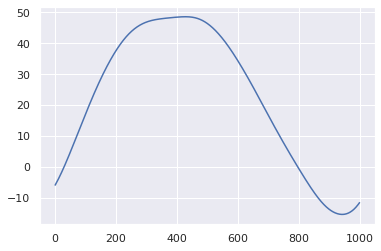

In [46]:
print(np.shape(transition1_mean_signal))
plt.plot(transition1_mean_signal[0])
plt.show()

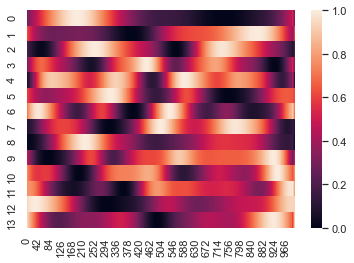

In [ ]:
ax = sns.heatmap(np.transpose(data_t1))

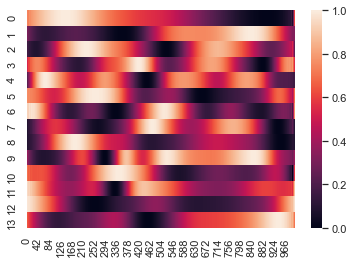

In [ ]:
ax = sns.heatmap(np.transpose(data_t2))